<a href="https://colab.research.google.com/github/SmartPracticeschool/SBSPS-Challenge-2700-Twitter-Sentiment-Analysis-Extraction-for-COVID-19/blob/master/Notebooks/Sentiment_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install -q transformers==2.1.1
!pip install -q torch

     |████████████████████████████████| 317kB 20.7MB/s 
     |████████████████████████████████| 1.1MB 44.5MB/s 
     |████████████████████████████████| 890kB 55.2MB/s 


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

#Sentiment Analyzer

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [ ]:
model_type = 'roberta'
pretrained_model_name = 'roberta-base'

model_class, tokenizer_class, config_class = RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

pad_idx = transformer_tokenizer.pad_token_id

100%|██████████| 456318/456318 [00:00<00:00, 18590751.06B/s]


In [ ]:
path = '/content/drive/My Drive/IBM_Hackathon_2020/Roberta_Model'
learner = load_learner(path, 'transformer.pkl')

In [ ]:
def predict_sentiment(text):
  sentiment = learner.predict(text)[1].item()
  return sentiment

def sentiment_label (Sentiment):
   if Sentiment == 2:
       return "positive"
   elif Sentiment == 0:
       return "negative"
   else :
       return "neutral"

In [ ]:
DATA_ROOT = Path("..") / '/content/drive/My Drive/IBM_Hackathon_2020/Final_Datasets/Test_India.csv'
predictions_test = pd.read_csv(DATA_ROOT)

predictions_test['Prediction'] = predictions_test['full_text'].apply(predict_sentiment)
predictions_test['Prediction_text'] = predictions_test['Prediction'].apply(sentiment_label)
class_names = ['negative','positive','neutral']

In [ ]:
predictions_test.head()

,id,full_text,retweet_count,Sentiment,Prediction,Prediction_text
0,1260158379936358400,Watch live tonight at 8 pm on LINK narendramod...,0,positive,2,positive
1,1269634025523642369,Enjoy piece of your own paradise Outdoorpool ...,0,positive,2,positive
2,1269117643312816128,Introduction to Security Operations Center SOC...,0,positive,2,positive
3,1267416133449273345,Lipsasingha3 AprilMay edition of लोककल्याणसेतु...,0,positive,0,negative
4,1267528967424270342,Dr Pankaj Shah aged 65\nM D Physician\nExpired...,1,negative,0,negative


In [ ]:
print(classification_report(predictions_test['Sentiment'], predictions_test['Prediction_text'], target_names=class_names))

              precision    recall  f1-score   support

    negative       0.70      0.70      0.70       429
    positive       0.89      0.85      0.87      1031
     neutral       0.88      0.91      0.90      1710

    accuracy                           0.86      3170
   macro avg       0.83      0.82      0.82      3170
weighted avg       0.86      0.86      0.86      3170



In [ ]:
cf = confusion_matrix(predictions_test['Sentiment'],predictions_test['Prediction_text'])

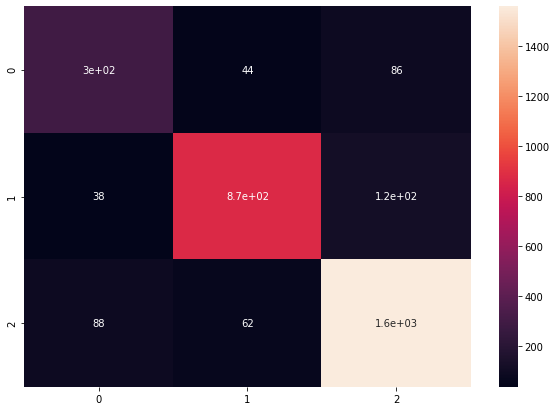

In [ ]:
#Plotting the Confusion matrix using Seaborn Library
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize = (10,7))
sn.heatmap(cf,annot=True)

#Real-Time Twitter Scrapper

In [ ]:
#Defining functions for Cleaning and Normalization of Data
import re
import string
def replace_url(string): # cleaning of URL
    text = re.sub(r'http\S+', 'LINK', string)
    return text


def replace_email(text):#Cleaning of Email related text
    line = re.sub(r'[\w\.-]+@[\w\.-]+','MAIL',str(text))
    return "".join(line)

def rep(text):#cleaning of non standard words
    grp = text.group(0)
    if len(grp) > 3:
        return grp[0:2]
    else:
        return grp# can change the value here on repetition
def unique_char(rep,sentence):
    convert = re.sub(r'(\w)\1+', rep, sentence) 
    return convert

def find_dollar(text):#Finding the dollar sign in the text
    line=re.sub(r'\$\d+(?:\.\d+)?','PRICE',text)
    return "".join(line)

def replace_emoji(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text) 

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']

def clean_text(text: str) -> str:
    text = str(text)
    for punct in puncts + list(string.punctuation):
        if punct in text:
            text = text.replace(punct, f'')
    return text
   
def replace_asterisk(text):
    text = re.sub("\*", 'ABUSE ', text)
    return text

def remove_duplicates(text):
    text = re.sub(r'\b(\w+\s*)\1{1,}', '\\1', text)
    return text

def change(text):
    if(text == ''):
        return text
  #calling the subfunctions in the cleaning function
    text = replace_email(text)
    text = replace_url(text)
    text = unique_char(rep,text)
    text = replace_asterisk(text)
    text = remove_duplicates(text)
    text = clean_text(text)
    return text

In [ ]:
    # Import libraries
from tweepy import OAuthHandler
#from tweepy.streaming import StreamListener
import tweepy
import csv
import pandas as pd
#import re
#from textblob import TextBlob
#import string
#import preprocessor as p
#import os
import time

# Twitter credentials
consumer_key = ''
consumer_secret = ''
access_key = ''
access_secret = ''

# Pass your twitter credentials to tweepy via its OAuthHandler
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

def extract_tweets(search_words,date_since,numTweets):
  return(tweepy.Cursor(api.search, q=search_words, lang="en", since=date_since, tweet_mode='extended').items(numTweets))


In [ ]:
def scraptweets(search_words, date_since, numTweets, numRuns):
    # Define a pandas dataframe to store the date:
    db_tweets = pd.DataFrame(columns = ['username', 'acctdesc', 'location', 'following', 'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts', 'retweetcount', 'text', 'hashtags'])
    #db_tweets = pd.DataFrame()

    for i in range(numRuns):

        tweets = extract_tweets(search_words,date_since,numTweets)
        # Store these tweets into a python list
        tweet_list = [tweet for tweet in tweets]
        print(len(tweet_list))
        noTweets = 0

        for tweet in tweet_list:
            username = tweet.user.screen_name
            acctdesc = tweet.user.description
            location = tweet.user.location
            following = tweet.user.friends_count
            followers = tweet.user.followers_count
            totaltweets = tweet.user.statuses_count
            usercreatedts = tweet.user.created_at
            tweetcreatedts = tweet.created_at
            retweetcount = tweet.retweet_count
            hashtags = tweet.entities['hashtags']
            lst=[]
            for h in hashtags:
                lst.append(h['text'])
            try:
                text = tweet.retweeted_status.full_text
            except AttributeError:  # Not a Retweet
                text = tweet.full_text

            itweet = [username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,lst]
            db_tweets.loc[len(db_tweets)] = itweet

            noTweets += 1
            print(noTweets)

            #filename = "tweets.csv"
            #with open(filename, "a", newline='') as fp:
             #   wr = csv.writer(fp, dialect='excel')
              #  wr.writerow(itweet)

        print('no. of tweets scraped for run {} is {}'.format(i + 1, noTweets))
        if i+1 != numRuns:
            time.sleep(920)

        filename = "/content/drive/My Drive/IBM_Hackathon_2020/Real-time-Data/tweets.csv"
        db_tweets['text'] = db_tweets['text'].apply(change)
        db_tweets = db_tweets[['tweetcreatedts', 'retweetcount', 'text']]
        # Store dataframe in csv with creation date timestamp
        db_tweets.to_csv(filename, index = False)

In [ ]:
# Initialise these variables:

search_words = "#India AND #COVID-19"
date_since = "2020-04-29"
#date_until = "2020-05-01"
numTweets = 2500
numRuns = 1
# Call the function scraptweets
program_start = time.time()
scraptweets(search_words, date_since, numTweets, numRuns)
program_end = time.time()
print('Scraping has completed!')
print('Total time taken to scrap is {} minutes.'.format(round(program_end - program_start)/60, 2))

#Real-Time Data Analysis

In [ ]:
path = '/content/drive/My Drive/IBM_Hackathon_2020/Real-time-Data/tweets.csv'
predictions = pd.read_csv(path)

predictions['Prediction'] = predictions['text'].apply(predict_sentiment)
predictions['Prediction'] = predictions['Prediction'].apply(sentiment_label)
class_names = ['negative','positive','neutral']

In [ ]:
predictions.head(10)

,retweetcount,text,sentiment
0,0,✅ ACC ✅\n\nAcc can give Good Breakdown in comi...,positive
1,0,So Pakistan just admitted what India has been ...,neutral
2,0,The nationwide lockdown in India which was to ...,negative
3,0,COVID 19 cases in India until 250620 2030\n\n...,positive
4,2,A Watch Worth 385 CroresFacts About 5M Luxury ...,positive
5,2,States of india and their capitals\nLINK\nIndi...,neutral
6,1,Total confirmed COVID19 cases in Telangana Ind...,positive
7,3,CBSE Board Exams 20 CBSE board exams for class...,negative
8,0,NEW DesilandNA How has India managed the COVID...,positive
9,0,Indian TV media should shift its base to Pakis...,positive


In [ ]:
predictions.rename(columns={'Prediction':'sentiment'},inplace=True)

In [ ]:
predictions.head()

,retweetcount,text,sentiment
0,0,✅ ACC ✅\n\nAcc can give Good Breakdown in comi...,positive
1,0,So Pakistan just admitted what India has been ...,neutral
2,0,The nationwide lockdown in India which was to ...,negative
3,0,COVID 19 cases in India until 250620 2030\n\n...,positive
4,2,A Watch Worth 385 CroresFacts About 5M Luxury ...,positive


In [ ]:
predictions = predictions.drop(['tweetcreatedts'],axis=1)

In [ ]:
predictions.head()

,retweetcount,text,sentiment
0,0,✅ ACC ✅\n\nAcc can give Good Breakdown in comi...,positive
1,0,So Pakistan just admitted what India has been ...,neutral
2,0,The nationwide lockdown in India which was to ...,negative
3,0,COVID 19 cases in India until 250620 2030\n\n...,positive
4,2,A Watch Worth 385 CroresFacts About 5M Luxury ...,positive


In [ ]:
predictions.to_csv('/content/drive/My Drive/IBM_Hackathon_2020/Real-time-Data/tweets.csv',index=False)